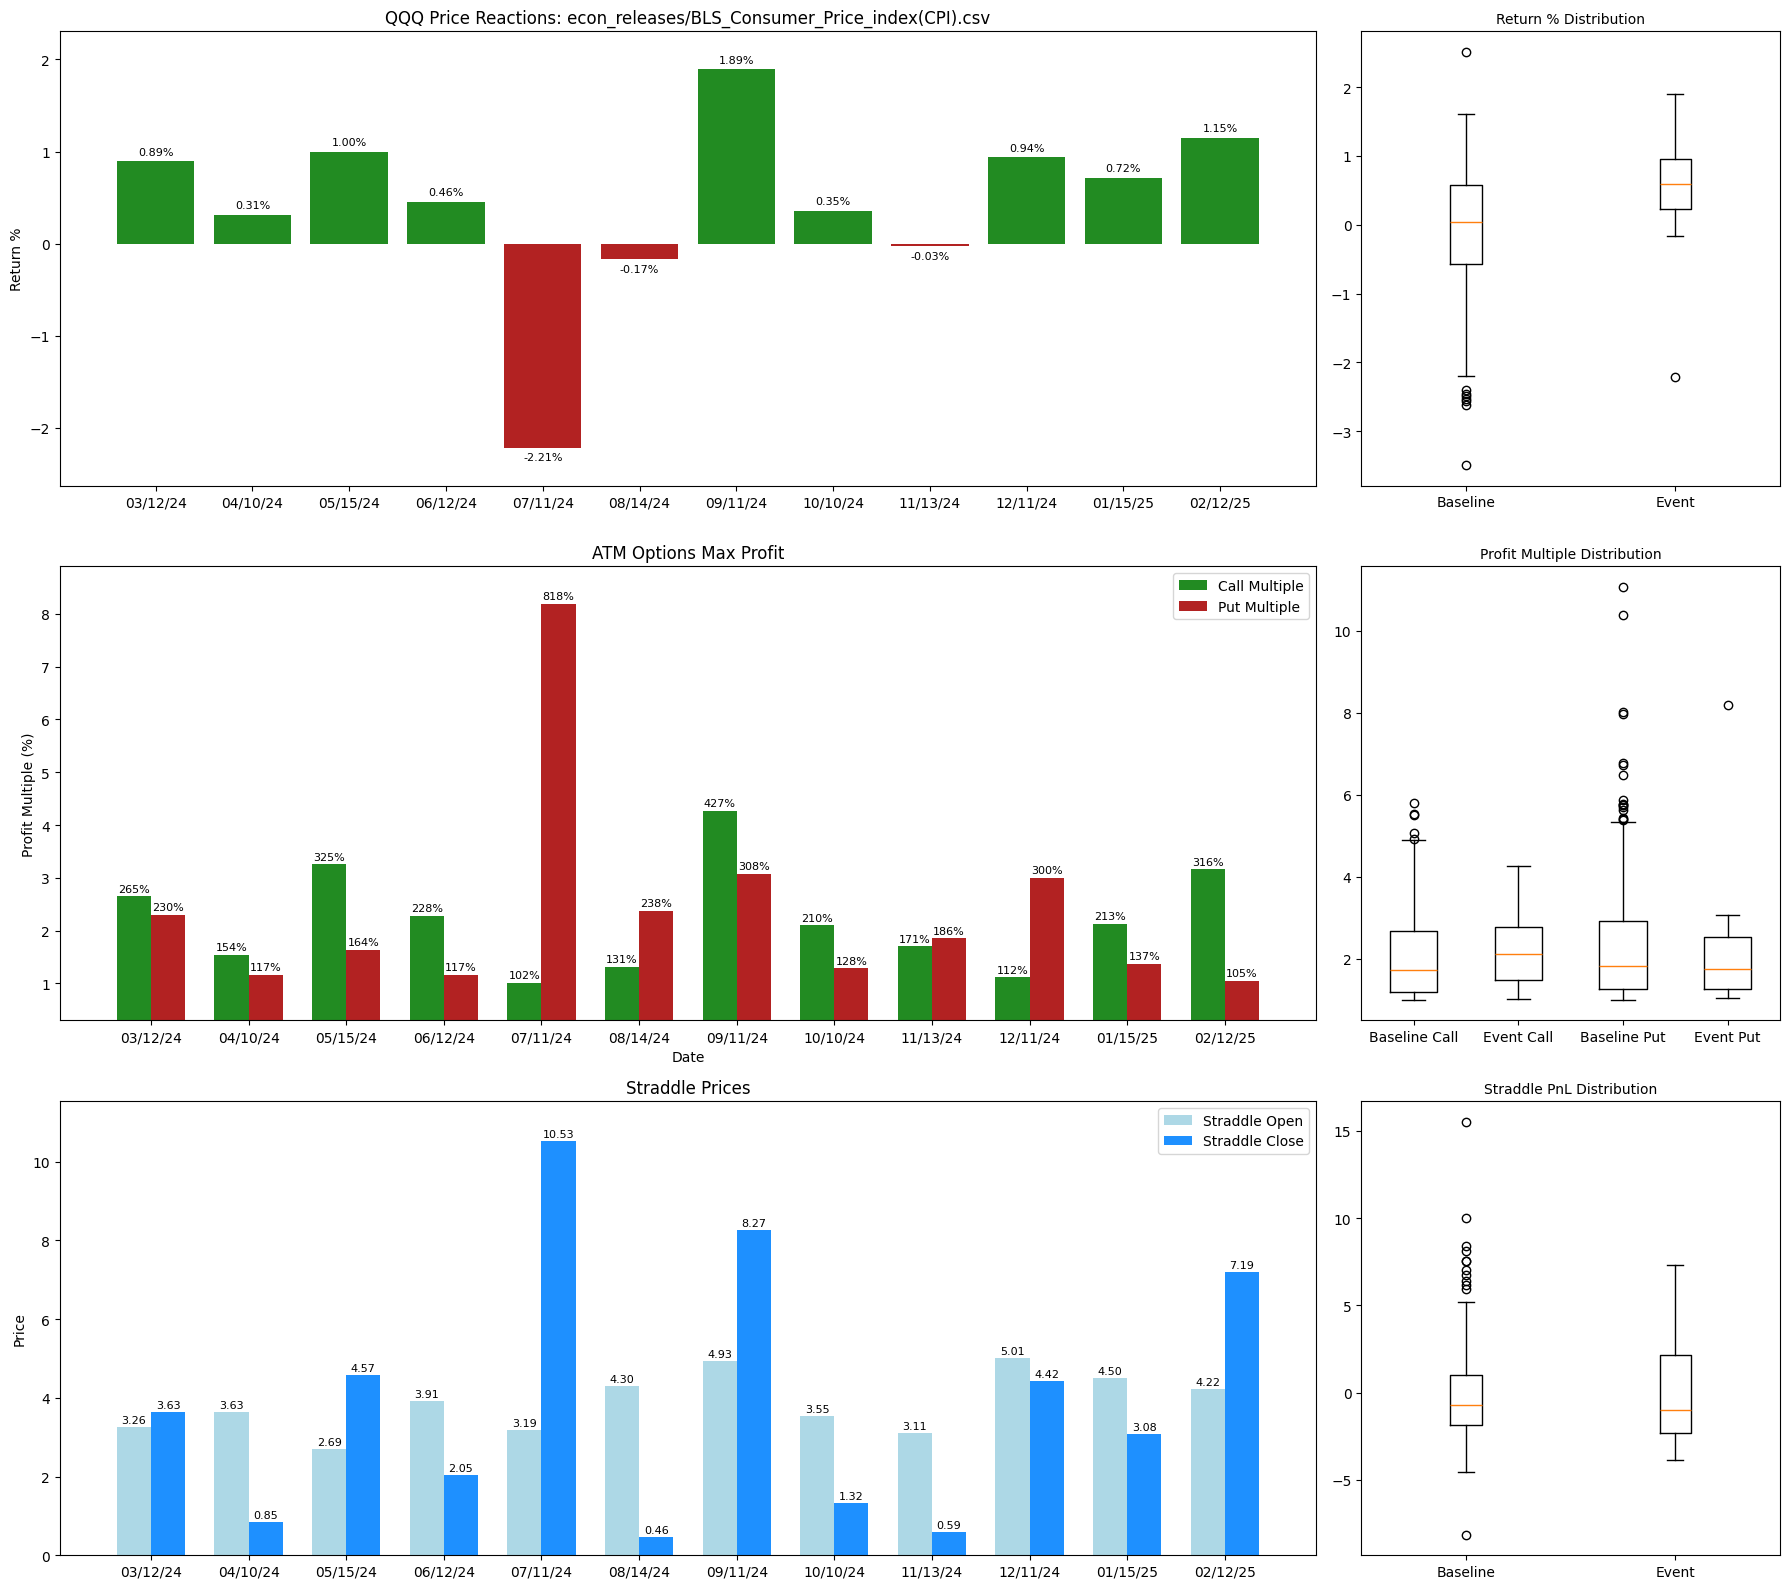

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_price_reactions_with_straddle(csv_file, year: int, options_file="QQQ_options_data.csv"):
    """
    Plot price reactions, straddle prices, and max profit multiples for ATM options with side boxplots comparing events to baseline.

    Args:
    csv_file (str): Path to the CSV file containing event dates
    year (int): Starting year for the analysis
    options_file (str): Path to the CSV file containing options data
    """
    # Read and process main price data
    df = pd.read_csv('NQ_QQQ_ATR.csv')
    df['time'] = pd.to_datetime(df['time'], errors='coerce')
    df = df[(df['time'].dt.year >= year) & (df['time'].dt.year <= 2025)]
    df = df.sort_values('time')
    df.loc[:, 'OC_Return'] = ((df['QQQ · NASDAQ: close'] - df['QQQ · NASDAQ: open']) / 
                              df['QQQ · NASDAQ: open']) * 100

    # Read and process event dates
    dates_df = pd.read_csv(csv_file)
    dates_df.columns = [col.strip('"') for col in dates_df.columns]
    event_dates = pd.to_datetime(dates_df.iloc[:, 0].str.strip('"').tolist())
    
    # Read options data
    options_df = pd.read_csv(options_file)
    options_df['Date'] = pd.to_datetime(options_df['Date'], errors='coerce')

    # Merge with options data
    full_df = df.merge(options_df[['Date', 'Straddle Open', 'Straddle Close', 
                                  'Call Open', 'Call High', 'Put Open', 'Put High']], 
                       left_on='time', right_on='Date', how='left')

    # Calculate metrics
    full_df['OC_Return'] = ((full_df['QQQ · NASDAQ: close'] - full_df['QQQ · NASDAQ: open']) / 
                            full_df['QQQ · NASDAQ: open']) * 100
    full_df['Call_Multiple'] = (full_df['Call High'] / full_df['Call Open']).fillna(0)
    full_df['Put_Multiple'] = (full_df['Put High'] / full_df['Put Open']).fillna(0)
    full_df['Straddle_PnL'] = (full_df['Straddle Close'] - full_df['Straddle Open']).fillna(0)

    # Filter event data and take last 12
    df_event = full_df[full_df['time'].isin(event_dates)].copy()
    last_12 = df_event.tail(12).copy()
    last_12['Date_Label'] = last_12['time'].dt.strftime('%m/%d/%y')

    # Define baseline period
    baseline_start = last_12['time'].min()
    baseline_df = full_df[(full_df['time'] >= baseline_start) & 
                          (~full_df['time'].isin(event_dates))].copy()

    # Create figure with 3x2 subplots
    fig, axes = plt.subplots(3, 2, figsize=(18, 16), gridspec_kw={'width_ratios': [3, 1]})

    # Plot 1: Price Reactions (left) and Boxplot (right)
    ax1, ax1_box = axes[0, 0], axes[0, 1]
    bars = ax1.bar(last_12['Date_Label'], last_12['OC_Return'],
                   color=['firebrick' if x < 0 else 'forestgreen' for x in last_12['OC_Return']],
                   width=0.8)
    min_return = last_12['OC_Return'].min()
    max_return = last_12['OC_Return'].max()
    buffer = (max_return - min_return) * 0.1
    ax1.set_ylim(min_return - buffer, max_return + buffer)
    ax1.set_title(f'QQQ Price Reactions: {csv_file}', fontsize=12)
    ax1.set_ylabel('Return %', fontsize=10)
    for bar in bars:
        height = bar.get_height()
        y_position = height + 0.05 if height > 0 else height - 0.05
        va = 'bottom' if height > 0 else 'top'
        ax1.text(bar.get_x() + bar.get_width()/2, y_position,
                 f'{height:.2f}%', ha='center', va=va, fontsize=8)

    event_returns = last_12['OC_Return'].dropna()
    baseline_returns = baseline_df['OC_Return'].dropna()
    ax1_box.boxplot([baseline_returns, event_returns], tick_labels=['Baseline', 'Event'])
    ax1_box.set_title('Return % Distribution', fontsize=10)

    # Plot 2: Max Profit Multiples (left) and Boxplot (right)
    ax2, ax2_box = axes[1, 0], axes[1, 1]
    x = np.arange(len(last_12['Date_Label']))
    bar_width = 0.35
    call_bars = ax2.bar(x - bar_width/2, last_12['Call_Multiple'],
                        bar_width, label='Call Multiple', color='forestgreen')
    put_bars = ax2.bar(x + bar_width/2, last_12['Put_Multiple'],
                       bar_width, label='Put Multiple', color='firebrick')
    ax2.set_title('ATM Options Max Profit', fontsize=12)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Profit Multiple (%)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(last_12['Date_Label'], rotation=0)
    ax2.legend()
    for bars in (call_bars, put_bars):
        for bar in bars:
            height = bar.get_height()
            if height != 0:
                ax2.text(bar.get_x() + bar.get_width()/2, height + 0.05,
                         f'{height*100:.0f}%', ha='center', va='bottom', fontsize=8)
    valid_multiples = last_12[['Call_Multiple', 'Put_Multiple']].stack().replace(0, np.nan).dropna()
    if len(valid_multiples) > 0:
        max_multiple = valid_multiples.max()
        min_multiple = valid_multiples.min()
        multiple_buffer = (max_multiple - min_multiple) * 0.1
        ax2.set_ylim(max(0, min_multiple - multiple_buffer), max_multiple + multiple_buffer)

    event_call = last_12['Call_Multiple'].replace(0, np.nan).dropna()
    event_put = last_12['Put_Multiple'].replace(0, np.nan).dropna()
    baseline_call = baseline_df['Call_Multiple'].replace(0, np.nan).dropna()
    baseline_put = baseline_df['Put_Multiple'].replace(0, np.nan).dropna()
    ax2_box.boxplot([baseline_call, event_call, baseline_put, event_put], 
                    tick_labels=['Baseline Call', 'Event Call', 'Baseline Put', 'Event Put'])
    ax2_box.set_title('Profit Multiple Distribution', fontsize=10)

    # Plot 3: Straddle Open and Close (left) and Boxplot (right)
    ax3, ax3_box = axes[2, 0], axes[2, 1]
    x = np.arange(len(last_12['Date_Label']))
    bar_width = 0.35
    open_bars = ax3.bar(x - bar_width/2, last_12['Straddle Open'].fillna(0),
                        bar_width, label='Straddle Open', color='lightblue')
    close_bars = ax3.bar(x + bar_width/2, last_12['Straddle Close'].fillna(0),
                         bar_width, label='Straddle Close', color='dodgerblue')
    ax3.set_title('Straddle Prices', fontsize=12)
    ax3.set_ylabel('Price')
    ax3.set_xticks(x)
    ax3.set_xticklabels(last_12['Date_Label'], rotation=0)
    ax3.legend()
    for bars in (open_bars, close_bars):
        for bar in bars:
            height = bar.get_height()
            if height != 0:
                ax3.text(bar.get_x() + bar.get_width()/2, height + 0.05,
                         f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    valid_prices = last_12[['Straddle Open', 'Straddle Close']].stack().dropna()
    if len(valid_prices) > 0:
        max_price = valid_prices.max()
        min_price = valid_prices.min()
        price_buffer = (max_price - min_price) * 0.1
        ax3.set_ylim(max(0, min_price - price_buffer), max_price + price_buffer)

    baseline_pnl = baseline_df['Straddle_PnL'].dropna()
    event_pnl = last_12['Straddle_PnL'].dropna()
    ax3_box.boxplot([baseline_pnl, event_pnl], tick_labels=['Baseline', 'Event'])
    ax3_box.set_title('Straddle PnL Distribution', fontsize=10)


    plt.tight_layout()
    plt.show()

data = 'BLS_Consumer_Price_index(CPI).csv'
plot_price_reactions_with_straddle('econ_releases/' + data, 2013)